In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 500)
relativePathImages = '../latex/src/images/'

## Obtengo el listado de palabras que aparecen más de 40 veces y dichas por más de 5 usuarios

In [2]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")

fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

Calculo la entropía de las palabras y de las personas, así como de las cantidades reordenadas aleatoriamente. 

También agrego la columna de las frecuencias normalizadas.

In [3]:
from iv_helpers import simulated_shuffled_entropy_multinomial
np.random.seed(seed=1)
fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**,**el**,etc. dejan de tener tanto valor de información

In [4]:
import math
df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())

Agrego la columna *esLugar* para poder filtrar las palabras más rapidamente

In [5]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


### Normalizo el valor de la cantidad de ocurrencias de una palabra y de usuarios que la utilizan.

$$ norm_{CantPalabras} = \frac{log_2(\#Palabra)- min(log_2(\#Palabra))}{max(log_2(\#Palabra)) - min(log_2(\#Palabra))}$$

$$norm_{CantPersonas} = \frac{log_2(\#Usuarios)- min(log_2(\#Usuarios))}{max(log_2(\#Usuarios)) - min(log_2(\#Usuarios))}$$

De esta forma, estos dos valores están en el rango 0-1

La métrica llamada $InformationValue_{PersonasPalabras}$

$$InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras})$$

donde $\widehat{H}$ es la entropía con las cantidades distribuidas uniformemente y H es la entropía común

In [6]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['fnormArgentina','cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,fnormArgentina,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,,
chivilcoy,2.161422e-05,4074,lugar,469,buenosaires,4,5,1,0.532714,0.379500,3.101728,0.558161
oberá,2.292996e-05,4322,lugar,378,misiones,3,3,2,0.506352,0.384377,3.116717,0.569656
ushuaia,7.940069e-05,14966,lugar,1006,tierradelfuego,1,53,3,0.625981,0.486874,3.123585,1.453279
ush,1.133765e-05,2137,ok,465,tierradelfuego,11,4,4,0.531668,0.326256,3.121715,0.362702
obera,1.117318e-05,2106,lugar,410,misiones,17,10,5,0.516283,0.325050,3.115185,0.543877
breñas,1.374100e-05,2590,lugar,170,chaco,6,2,6,0.408690,0.342121,3.070409,0.232404
viedma,3.493079e-05,6584,lugar,666,rionegro,7,54,7,0.575573,0.419112,3.118042,1.294115
bragado,1.488166e-05,2805,lugar,294,buenosaires,9,11,8,0.475637,0.348702,3.086379,0.619135
logroño,1.375161e-05,2592,lugar,132,larioja,5,1,9,0.377771,0.342184,3.031223,0.089018


## Hago un dataframe con las palabras candidatas, cada una con las cantidades de ocurrencias por provincia de forma ordenada

In [7]:
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]

dfCant = df[cant]
# Palabras candidatas según la AAL
palabras = ["quedarla","mitaí","angá","yungas","mensajeras","yarco","yarca",
"malpegar","malpegue","malpegada","tareferos","hartante","guaracha","esar","ñeri",
"piadina","chombi","achilata","pollerear","juntadera","pachata","chamigo","chamiga",
"chaque","pichar","tortita","guaso","guasa","comparsero","comparsera","sina","lape","veme","porronear",
"fajita","jia","jía","asada","asar","manso","cora","cumpa","pingo","charro","pinchila","oyo","ura","yuto",
"yagua","cantobar","cha","bombolo","bombola","yafu","jal","gatera","atina",
"guampudo","guampuda","mamila","chui","tico"]


In [8]:
dfC = df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=False)[cant]

In [9]:
sort_xs = dfC.apply(np.sort, axis=1)
sort_index = dfC.apply(np.argsort, axis=1)
sort_xs.columns = range(23)
sort_index.columns = range(23)
cols = sort_xs.columns.tolist()
cols = cols[::-1]
sort_xs = sort_xs[cols]
sort_index = sort_index[cols]
sort_xs.columns= range(23)
sort_index.columns = range(23)

In [10]:
percent = sort_xs.div(sort_xs.sum(axis=1), axis='index')
percent.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
palabra,,,,,,,,,,,,,,,,,,,,,
chivilcoy,0.979872,0.003682,0.003436,0.002209,0.001718,0.001227,0.000982,0.000982,0.000736,0.000736,...,0.000736,0.000491,0.000245,0.000245,0.000245,0.000245,0.000000,0.000000,0.000000,0.000000
oberá,0.981953,0.007867,0.003702,0.001157,0.000925,0.000925,0.000694,0.000463,0.000463,0.000463,...,0.000231,0.000231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ushuaia,0.962649,0.006749,0.004410,0.003140,0.002339,0.002205,0.002071,0.001938,0.001871,0.001670,...,0.001270,0.000935,0.000802,0.000735,0.000535,0.000535,0.000535,0.000535,0.000535,0.000267
ush,0.981750,0.006551,0.001404,0.001404,0.000936,0.000936,0.000936,0.000936,0.000936,0.000468,...,0.000468,0.000468,0.000468,0.000468,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
obera,0.962013,0.014245,0.005223,0.002374,0.002374,0.002374,0.001899,0.001899,0.001425,0.000950,...,0.000950,0.000475,0.000475,0.000475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


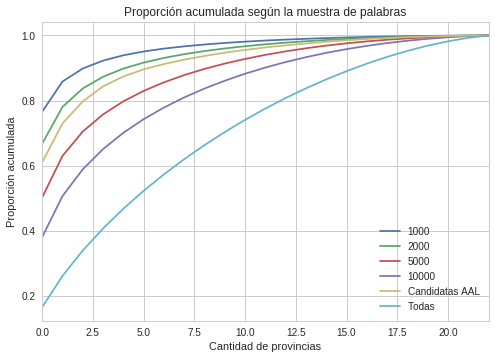

In [11]:
dfAcum = pd.DataFrame()
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum['2000'] = percent.iloc[:2000].cumsum(axis=1).mean()
dfAcum['5000'] = percent.iloc[:5000].cumsum(axis=1).mean()
dfAcum['10000'] = percent.iloc[:10000].cumsum(axis=1).mean()
dfAcum['Candidatas AAL'] = percent.loc[palabras].cumsum(axis=1).mean()
dfAcum['Todas'] = percent.cumsum(axis=1).mean()
ax = dfAcum.plot(kind='line')

ax.set_xlabel(u"Cantidad de provincias")
ax.set_ylabel(u"Proporción acumulada")
ax.set_title(u'Proporción acumulada según la muestra de palabras')
ax2= ax.get_figure()
ax2.savefig("{0}PropAcum.pdf".format(relativePathImages),dpi=300)

In [12]:
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum

,1000,2000,5000,10000,Candidatas AAL,Todas
0,0.765978,0.667815,0.502619,0.380862,0.610184,0.165523
1,0.858378,0.780477,0.630083,0.506757,0.729768,0.261680
2,0.898416,0.837181,0.704929,0.588935,0.797470,0.339650
3,0.922650,0.873071,0.757482,0.650990,0.843546,0.407328
4,0.938929,0.898167,0.797640,0.701089,0.873936,0.467869
5,0.950676,0.916567,0.829620,0.742823,0.895849,0.522942
6,0.959469,0.930808,0.855990,0.778537,0.912074,0.573430
7,0.966411,0.942454,0.878236,0.809596,0.925600,0.620024
8,0.972106,0.951972,0.897250,0.836870,0.936912,0.663217
9,0.976870,0.959999,0.913573,0.860955,0.946959,0.703381


In [13]:
df.iloc[:10000].cantPalabra.mean()

715.2056

In [14]:
df[(df.rankPalabras_Personas> 10000) &  ((df.rankPalabras< 2000) | (df.rankPersonas< 2000))][['entropy_personas','entropy_palabras','cantPalabra','cantUsuariosTotal','normCantPalabras','normCantPersonas']]

,entropy_personas,entropy_palabras,cantPalabra,cantUsuariosTotal,normCantPalabras,normCantPersonas
palabra,,,,,,
judejut,1.213008,0.838477,116,8,0.085824,0.035159
cmj,1.219137,1.055872,44,21,0.005827,0.153106
gift,3.058502,1.529343,1023,229,0.265465,0.445101
twich,1.643418,0.775350,71,10,0.045313,0.062430
biblico,1.791759,0.786223,142,12,0.102513,0.084713
modal,2.464508,0.970468,110,23,0.081441,0.164224
sojuela,0.000000,0.000000,56,7,0.025729,0.018839
salvia,2.306669,0.975751,101,16,0.074397,0.119872
confitear,0.178845,0.112516,42,23,0.001989,0.164224


In [15]:
df.loc['gift']

buenosairesPalabras                             11
catamarcaPalabras                                5
chacoPalabras                                    2
chubutPalabras                                  28
cordobaPalabras                                 12
corrientesPalabras                              11
entreriosPalabras                                6
formosaPalabras                                  7
jujuyPalabras                                   30
lapampaPalabras                                 16
lariojaPalabras                                706
mendozaPalabras                                 16
misionesPalabras                                 8
neuquenPalabras                                  6
rionegroPalabras                                22
saltaPalabras                                   16
sanjuanPalabras                                 20
sanluisPalabras                                 13
santacruzPalabras                               16
santafePalabras                

# Vemos como se distribuye la suma acumulada de proporciones de las palabras

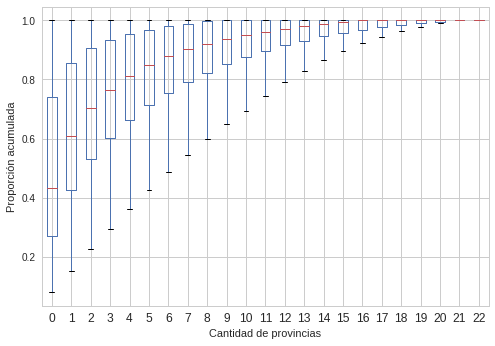

In [54]:
ax = percent.iloc[:5000].cumsum(axis=1).boxplot(return_type='axes')
# fig.subplots_adjust(hspace=.8)

ax.set_xlabel(u"Cantidad de provincias")
ax.set_ylabel(u"Proporción acumulada")
ax.get_figure().savefig("{0}PropAcum5000.pdf".format(relativePathImages),dpi=300)

In [17]:
regiones = pd.DataFrame()
regiones = percent.cumsum(axis=1)

def calc(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            return i+1
    
for thresh in np.arange(0.7,1,0.05):
    print "La media de provincias con threshold igual a " + str(thresh) + ": " + str(regiones[:5000].apply(calc,args=(thresh,),axis=1).mean())


La media de provincias con threshold igual a 0.7: 4.0424
La media de provincias con threshold igual a 0.75: 4.7482
La media de provincias con threshold igual a 0.8: 5.6118
La media de provincias con threshold igual a 0.85: 6.721
La media de provincias con threshold igual a 0.9: 8.264
La media de provincias con threshold igual a 0.95: 10.6422
La media de provincias con threshold igual a 1.0: 20.2752293578


### Me fijo la región que supera el úmbral por cada palabra

In [18]:
provincias = [x.replace("Palabras","") for x in cant]
def provs(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            cant = sort_index.loc[row.name].iloc[:i+1].tolist()
            return [provincias[x] for x in cant]

In [19]:
df['regionTest'] = regiones.apply(provs,args=(0.8,),axis=1)

In [20]:
def cantPalabrasTotalesEnRegion(provincias):
    return sum(dfR.loc[provincias,'cantTotal'])

def cantPalabrasWEnRegion(palabra,provincias):
    provs = [p+'Palabras' for p in provincias]
    return sum(dfcantPalabrasEnProvincia.loc[palabra,provs])
dfR = pd.read_csv('../cantidadesDataset.csv',index_col=0)
dfcantPalabrasEnProvincia = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",",index_col='palabra')


In [21]:
df['cantPalabrasTotalesEnRegion'] = df.regionTest.apply(cantPalabrasTotalesEnRegion)


In [24]:
df['cantPalabrasWEnRegion'] = df.apply(lambda x: cantPalabrasWEnRegion(x.name,x.regionTest),axis=1)


In [ ]:
cols = df.columns.tolist()
cols = [cols[-1]] + cols[:-1] 
df = df[cols]

## Guardo los listados (resumidos, y extendidos) ordenados en base a la métrica IV PersonasPalabras

In [27]:
df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','regionTest','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','cantPalabrasWEnRegion','cantPalabrasTotalesEnRegion']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')

df.to_csv('ivalue_entropia_personas_palabras.csv')

In [ ]:
sum(df.regionTest.map(lambda x: 'cordoba' in x and 'santafe' in x))

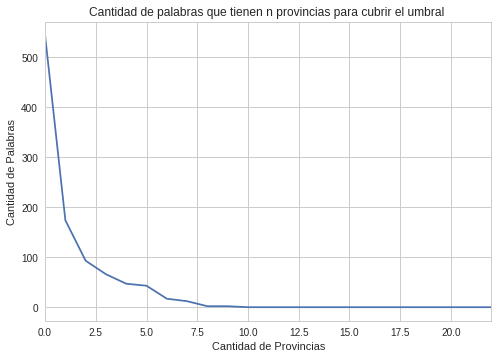

In [33]:
a = []
for i in range(1,24):
    cantProvincias = sum(df[:1000].regionTest.map(lambda x: len(x)==i))
    a.append(cantProvincias)
#     print str(i)+ ': ' + str(cantProvincias)
fig = pd.Series(a).plot(title='Cantidad de palabras que tienen n provincias para cubrir el umbral ')
fig.set_xlabel(xlabel='Cantidad de Provincias')
fig.set_ylabel(ylabel='Cantidad de Palabras')

In [35]:
df.iloc[:3000][df['regionTest'].map(len) > 1].regionTest.apply(lambda x : sorted(x[:6])).apply(tuple).value_counts()

/home/dami/tesis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(jujuy, salta)                                                              18
(mendoza, sanjuan)                                                          18
(neuquen, rionegro)                                                         16
(chaco, corrientes)                                                         15
(chaco, corrientes, formosa)                                                13
(catamarca, jujuy, larioja, salta, santiago, tucuman)                       12
(chubut, santacruz)                                                         11
(cordoba, larioja)                                                          11
(corrientes, misiones)                                                      11
(corrientes, formosa, misiones)                                             11
(formosa, misiones)                                                         11
(catamarca, larioja)                                                        10
(catamarca, salta, santiago, tucuman)               

In [36]:
df[df.regionTest.map(lambda x: 'chaco' in x and 'corrientes' in x )].regionTest

palabra
ctes                                                [corrientes, chaco]
nae                                                 [corrientes, chaco]
resis                                               [chaco, corrientes]
anga                                       [corrientes, formosa, chaco]
teres                             [chaco, formosa, corrientes, lapampa]
corrientes                                [corrientes, chaco, misiones]
recep                           [chaco, corrientes, formosa, entrerios]
correntinos                                         [corrientes, chaco]
correntino                               [corrientes, chaco, entrerios]
unne                                                [corrientes, chaco]
chaco                              [chaco, corrientes, misiones, salta]
alpedo                [formosa, misiones, corrientes, tierradelfuego...
correntina                                [corrientes, chaco, misiones]
teresss                                    [chaco, formo

In [37]:
print 'Hay {0} lugares en las primeras 5000 palabras.'.format(len(df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar']))

Hay 608 lugares en las primeras 5000 palabras.


In [38]:
p1 = df.sort_values(by='information_value_palabras',ascending=False)[:5000].index
p2 =  df.sort_values(by='information_value_personas',ascending=False)[:5000].index
p3 =  df.sort_values(by='information_value_personas_palabras',ascending=False)[:5000].index
interseccion = set(p2) & set(p3) & set(p1)
len(interseccion)

2908

In [ ]:
from scipy.stats import hypergeom, poisson, norm

dfR = pd.read_csv('../cantidadesDataset.csv',index_col=0)
dfcantPalabrasEnProvincia = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",",index_col='palabra')
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]
palabrasEnArgentina = 192348167
def cantPalabrasTotalesEnRegion(provincias):
    return sum(dfR.loc[provincias,'cantTotal'])

def cantPalabrasWEnRegion(palabra,provincias):
    provs = [p+'Palabras' for p in provincias]
    return sum(dfcantPalabrasEnProvincia.loc[palabra,provs])


def cantPalabraWEnArgentina(palabra):
    return dfcantPalabrasEnProvincia.loc[palabra,'cantPalabra']

def calcularPValor(palabra,cantWRegion,cantTotRegion):
    
    M = 192348167 # Cantidad de palabras en toda la Argentina 
    n = dfcantPalabrasEnProvincia.loc[palabra,'cantPalabra'] # Cantidad de palabras w en toda la Argentina 
    N = cantTotRegion # Cantidad de palabras en la region    
    h0 = cantWRegion
    pvalue =  hypergeom.logsf(h0, M, n, N) 
    return pvalue


In [ ]:
df.iloc[0:10].apply(lambda x: calcularPValor(x.name,x.cantPalabrasWEnRegion,x.cantPalabrasTotalesEnRegion), axis=1)
#

In [ ]:
# df['pvalor'] = df.apply(lambda x: calcularPValor(x.name,x.cantPalabrasWEnRegion,x.cantPalabrasTotalesEnRegion), axis=1)
# df.to_csv('PVALORESivalue_entropia_personas_palabras.csv')

In [ ]:
dfP = pd.read_csv('PVALORESivalue_entropia_personas_palabras.csv')

In [46]:
pvalores = pd.read_csv('../pvalores.csv',index_col=0)

In [47]:
pvalores

,palabra,cantPalabra,esLugar,regionTest,cantUsuariosTotal,fnormArgentina,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,cantPalabrasWEnRegion,cantPalabrasTotalesEnRegion,pvalor
1,chivilcoy,4074.0,lugar,['buenosaires'],469.0,2.161422e-05,buenosaires,4.0,5.0,1.0,3992.0,8974372.0,0.000000e+00
2,oberá,4322.0,lugar,['misiones'],378.0,2.292996e-05,misiones,3.0,3.0,2.0,4244.0,7790197.0,0.000000e+00
3,ushuaia,14966.0,lugar,['tierradelfuego'],1006.0,7.940069e-05,tierradelfuego,1.0,53.0,3.0,14407.0,8559218.0,0.000000e+00
4,ush,2137.0,ok,['tierradelfuego'],465.0,1.133765e-05,tierradelfuego,11.0,4.0,4.0,2098.0,8559218.0,0.000000e+00
5,obera,2106.0,lugar,['misiones'],410.0,1.117318e-05,misiones,17.0,10.0,5.0,2026.0,7790197.0,0.000000e+00
6,breñas,2590.0,lugar,['chaco'],170.0,1.374100e-05,chaco,6.0,2.0,6.0,2577.0,7605991.0,0.000000e+00
7,viedma,6584.0,lugar,['rionegro'],666.0,3.493079e-05,rionegro,7.0,54.0,7.0,6178.0,9991831.0,0.000000e+00
8,bragado,2805.0,lugar,['buenosaires'],294.0,1.488166e-05,buenosaires,9.0,11.0,8.0,2723.0,8974372.0,0.000000e+00
9,logroño,2592.0,lugar,['larioja'],132.0,1.375161e-05,larioja,5.0,1.0,9.0,2590.0,6757277.0,0.000000e+00
10,nqn,2341.0,ok,['neuquen'],571.0,1.241995e-05,neuquen,39.0,21.0,10.0,2073.0,9021449.0,0.000000e+00


In [ ]:
pvalores.pvalor.describe()

In [ ]:
pvalores.iloc[0:10000].pvalor.describe()